In [1]:
import random
import warnings
from copy import deepcopy
from functools import partial
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from src.dataset_handler.classic_dataset import ClassicDataset
from src.models.lightning_wrapper import LightningWrapper
from src.models.multi_linear_layers import MultiLinearLayers
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import BinaryAccuracy

warnings.simplefilter("ignore")

In [2]:
# checkpoints = 'lightning_logs/version_23/checkpoints/epoch=49-step=5200.ckpt' # Keep it None if you want to train the model
checkpoints = None

df = pd.read_csv('../data/heart.csv')
df.sample(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
356,46,M,ASY,115,0,0,Normal,113,Y,1.5,Flat,1
20,43,F,TA,100,223,0,Normal,142,N,0.0,Up,0
390,51,M,ASY,140,0,0,Normal,60,N,0.0,Flat,1
63,46,M,ASY,120,277,0,Normal,125,Y,1.0,Flat,1
541,76,M,NAP,104,113,0,LVH,120,N,3.5,Down,1
448,63,M,ASY,160,230,1,Normal,105,Y,1.0,Flat,1
546,48,M,NAP,132,220,1,ST,162,N,0.0,Flat,1
481,69,M,NAP,140,0,1,ST,118,N,2.5,Down,1
588,67,M,ASY,140,219,0,ST,122,Y,2.0,Flat,1
299,47,M,ASY,110,0,1,ST,149,N,2.1,Up,1


Transformer :
- Age : Standardiser entre 0 et 1
- Sex : en binaire -> Homme = 0, Femme = 1
- ChestPainType : en variable catégorique
- RestingBP : Standardiser entre 0 et 1
- Cholesterol : Standardiser entre 0 et 1
- FastingBS : Ne rien faire (booléen)
- RestingECG : en variable catégorique
- MaxHR : Standardiser entre 0 et 1
- ExerciseAngina : en binaire -> N = 0, Y = 1
- Oldpeak : Standardiser entre 0 et 1
- ST_Slope : en variable catégorique
- HeartDisease : Ne rien faire (booléen)

In [3]:
def binarize_sex(sex: str) -> int:
    if sex.lower() == 'f':
        return 1
    else:
        return 0

def binarize_exercise_angina(exercise_angina: str) -> int:
    if exercise_angina.lower() == 'y':
        return 1
    else:
        return 0

In [4]:
transformers = {
    'Age': MinMaxScaler(),
    'RestingBP': MinMaxScaler(),
    'Cholesterol': MinMaxScaler(),
    'MaxHR': MinMaxScaler(),
    'Oldpeak': MinMaxScaler(),
    'ChestPainType': OneHotEncoder(),
    'RestingECG': OneHotEncoder(),
    'ST_Slope': OneHotEncoder(),
    'Sex': binarize_sex,
    'ExerciseAngina': binarize_exercise_angina
}

single_values_columns = []
multiple_values_columns = []
for column_name, preprocessor in transformers.items():
    if isinstance(preprocessor, MinMaxScaler):
        df[column_name] = preprocessor.fit_transform(df[column_name].to_numpy().reshape(-1, 1))
        single_values_columns.append(column_name)
    elif isinstance(preprocessor, OneHotEncoder):
        df[column_name] = preprocessor.fit_transform(df[column_name].to_numpy().reshape(-1, 1)).toarray().tolist()
        multiple_values_columns.append(column_name)
    else:
        df[column_name] = df[column_name].apply(lambda val: preprocessor(val))
        single_values_columns.append(column_name)

In [5]:
labels = df['HeartDisease'].to_numpy()

inputs_rows = []
columns_order = []
for _, row in df.drop(columns='HeartDisease').iterrows():
    arr_row = [row[coln] for coln in single_values_columns]
    [arr_row.extend(row[coln]) for coln in multiple_values_columns]

    columns_order = single_values_columns + multiple_values_columns

    inputs_rows.append(arr_row)

labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)
inputs = torch.tensor(inputs_rows)

In [6]:
dataset = ClassicDataset(inputs, labels)

total_size = len(dataset)
train_ratio = 0.9
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

In [7]:
network = MultiLinearLayers(inputs.shape[1], 1)
loss_function = nn.BCEWithLogitsLoss()

model = LightningWrapper(network, loss_function, metrics={'accuracy': BinaryAccuracy().to('cuda')})

if checkpoints is None:
    trainer = pl.Trainer(accelerator='gpu', max_epochs=10)

    trainer.fit(model, train_loader)
else:
    model.load_from_checkpoint(checkpoint_path=checkpoints, checkpoint_callback=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | wrapped_model | MultiLinearLayers | 535 K 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
535 K     Trainable params
0         Non-trainable params
535 K     Total params
2.142     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 104/104 [00:15<00:00,  6.61it/s, v_num=3, train_loss_step=0.0668, train_loss_epoch=0.326, train_accuracy=0.872]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 104/104 [00:20<00:00,  5.04it/s, v_num=3, train_loss_step=0.0668, train_loss_epoch=0.326, train_accuracy=0.872]


Bel entrainement maintenant, essayons de comprendre les distributions des neurones de chacune des couches, afin de savoir si c'est uniformément distribués où chaque neurone présente sa spécificité.

Récupérons le test set pour pouvoir commencer à travailler dessus. Un modèle simple + un cas binaire pour généraliser ensuite.

In [8]:
submodel = deepcopy(model.wrapped_model)

# Autant tout faire passer d'un coup
X_test = []
y_test = []
for x, y in test_set:
    X_test.append(x.unsqueeze(0))
    y_test.append(y)

X_test = torch.cat(X_test)
y_test = torch.cat(y_test)

# On peut chercher les logits du modèle
outputs = submodel(X_test)

BinaryAccuracy()(outputs, y_test.unsqueeze(1))

tensor(0.7935)

Super, maintenant entammons une analyse poussée de nos couches en sorties.

In [9]:
out_neurons_collector = {}
def forward_hook(module: nn.Module, inputs: torch.Tensor, outputs: torch.Tensor, name: str, out_neurons_collector: Dict[str, List[torch.Tensor]]) -> None:
    if name in out_neurons_collector.keys():
        out_neurons_collector[name].append(outputs.detach().cpu())
    else:
        out_neurons_collector[name] = [outputs.detach().cpu()]

hooks = []
for name, module in submodel.named_modules():
    if name != '':
        hooks.append(module.register_forward_hook(partial(forward_hook, name=name, out_neurons_collector=out_neurons_collector)))

outputs = submodel(X_test)

for h in hooks:
    h.remove()

for layer_name, neurons in out_neurons_collector.items():
    out_neurons_collector[layer_name] = deepcopy(torch.cat(out_neurons_collector[layer_name]))

In [10]:
out_neurons_collector['linear2'].mean(dim=0), out_neurons_collector['linear2'].std(dim=0)

(tensor([ 0.1395, -0.0135, -0.0836,  ...,  0.0071, -0.0824, -0.1136]),
 tensor([0.1779, 0.2238, 1.0684,  ..., 0.7816, 0.3885, 1.1512]))

Avons nous à faire à des distributions normales ? Un test statistique pourra nous le dire !

In [11]:
normal_samples = {}
shapiro_pvalues = {}

for layer_name, layer_tensor in out_neurons_collector.items():
    normal_samples[layer_name] = []
    shapiro_pvalues[layer_name] = []

    for i in range(layer_tensor.shape[1]):
        samples = layer_tensor[:, i]
        shapiro_test = stats.shapiro(samples)

        normal_samples[layer_name].append(True if shapiro_test.pvalue > 0.05 else False)
        shapiro_pvalues[layer_name].append(shapiro_test.pvalue)

    normal_samples[layer_name] = torch.BoolTensor(normal_samples[layer_name])
    shapiro_pvalues[layer_name] = torch.Tensor(shapiro_pvalues[layer_name])

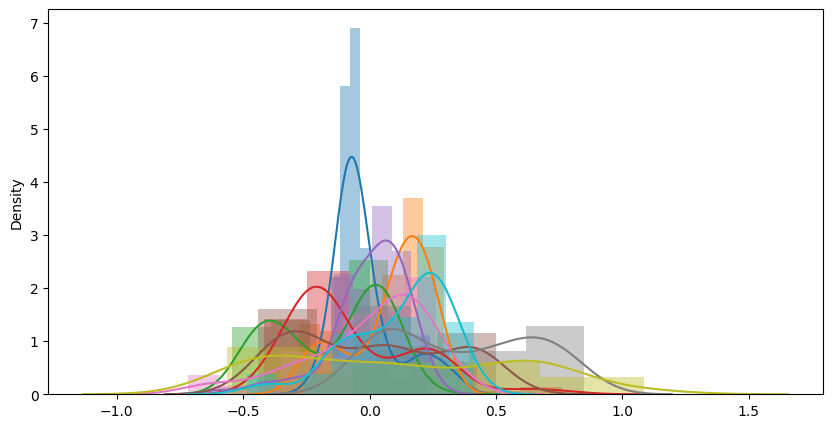

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

sorted_indices = shapiro_pvalues['linear1'].sort()[1][:10]
df_distplot = pd.DataFrame()
for c, ind in enumerate(sorted_indices):
    sns.distplot(out_neurons_collector['linear1'][:, ind.item()], ax=ax)

plt.show()

Souvent bimodal, c'est intéressant !

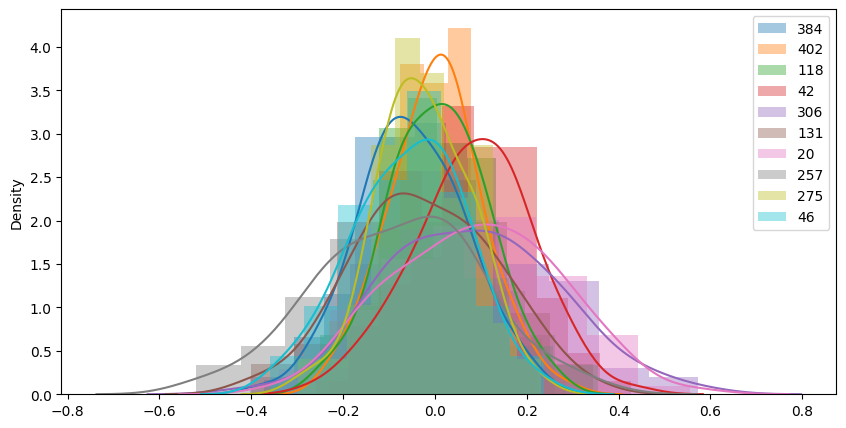

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

sorted_indices = shapiro_pvalues['linear1'].sort(descending=True)[1][:10]
df_distplot = pd.DataFrame()
for c, ind in enumerate(sorted_indices):
    sns.distplot(out_neurons_collector['linear1'][:, ind.item()], ax=ax, label=ind)

plt.legend()
plt.show()

Ont-ils simplement un effet régularisateur ?

Dans deux cas, où se situent les valeurs pour la classe 0 et la classe 1 ?

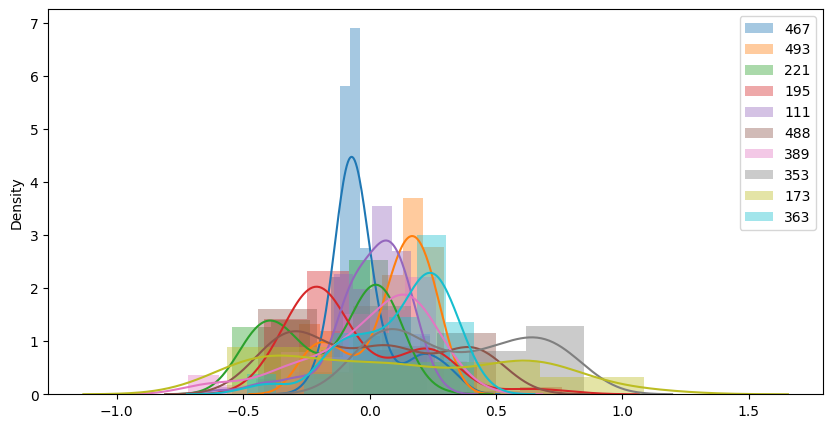

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

sorted_indices = shapiro_pvalues['linear1'].sort()[1][:10]
df_distplot = pd.DataFrame()
for c, ind in enumerate(sorted_indices):
    sns.distplot(out_neurons_collector['linear1'][:, ind.item()], ax=ax, label=ind)

plt.legend()
plt.show()

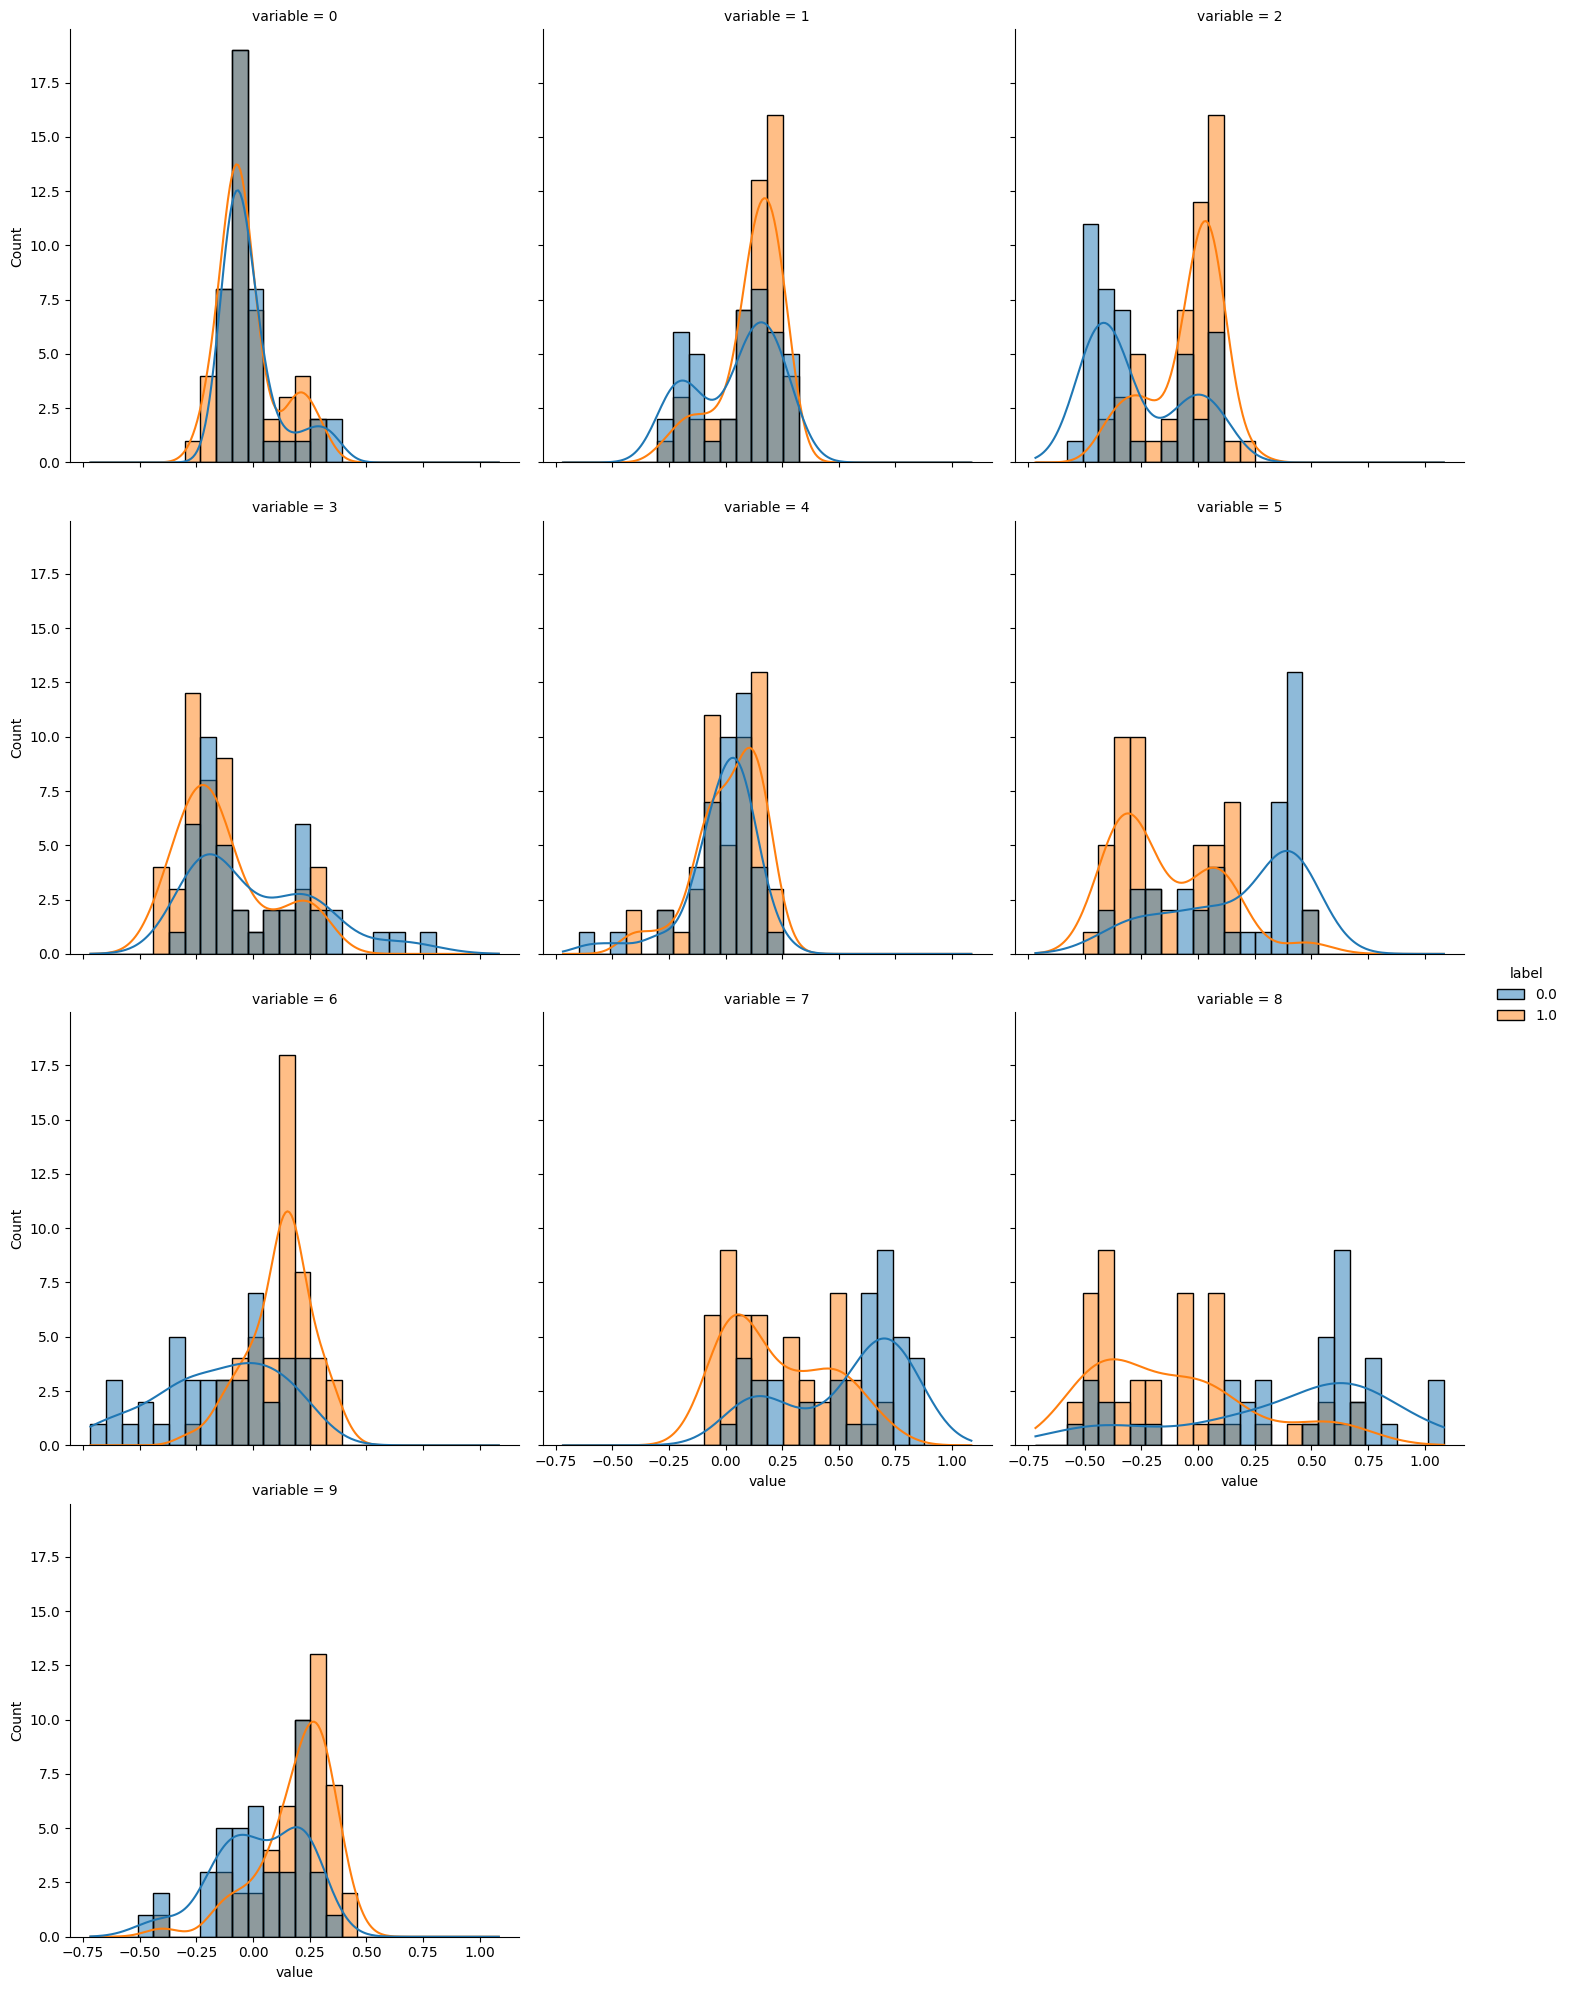

In [15]:
sorted_indices = shapiro_pvalues['linear1'].sort()[1][:10]

df_linear_1_unnormal = pd.DataFrame(data=out_neurons_collector['linear1'][:, sorted_indices])
df_linear_1_unnormal['label'] = y_test

sns.displot(data=df_linear_1_unnormal.melt(id_vars=['label']), x='value', hue='label', col='variable', col_wrap=3, alpha=0.5, kde=True);

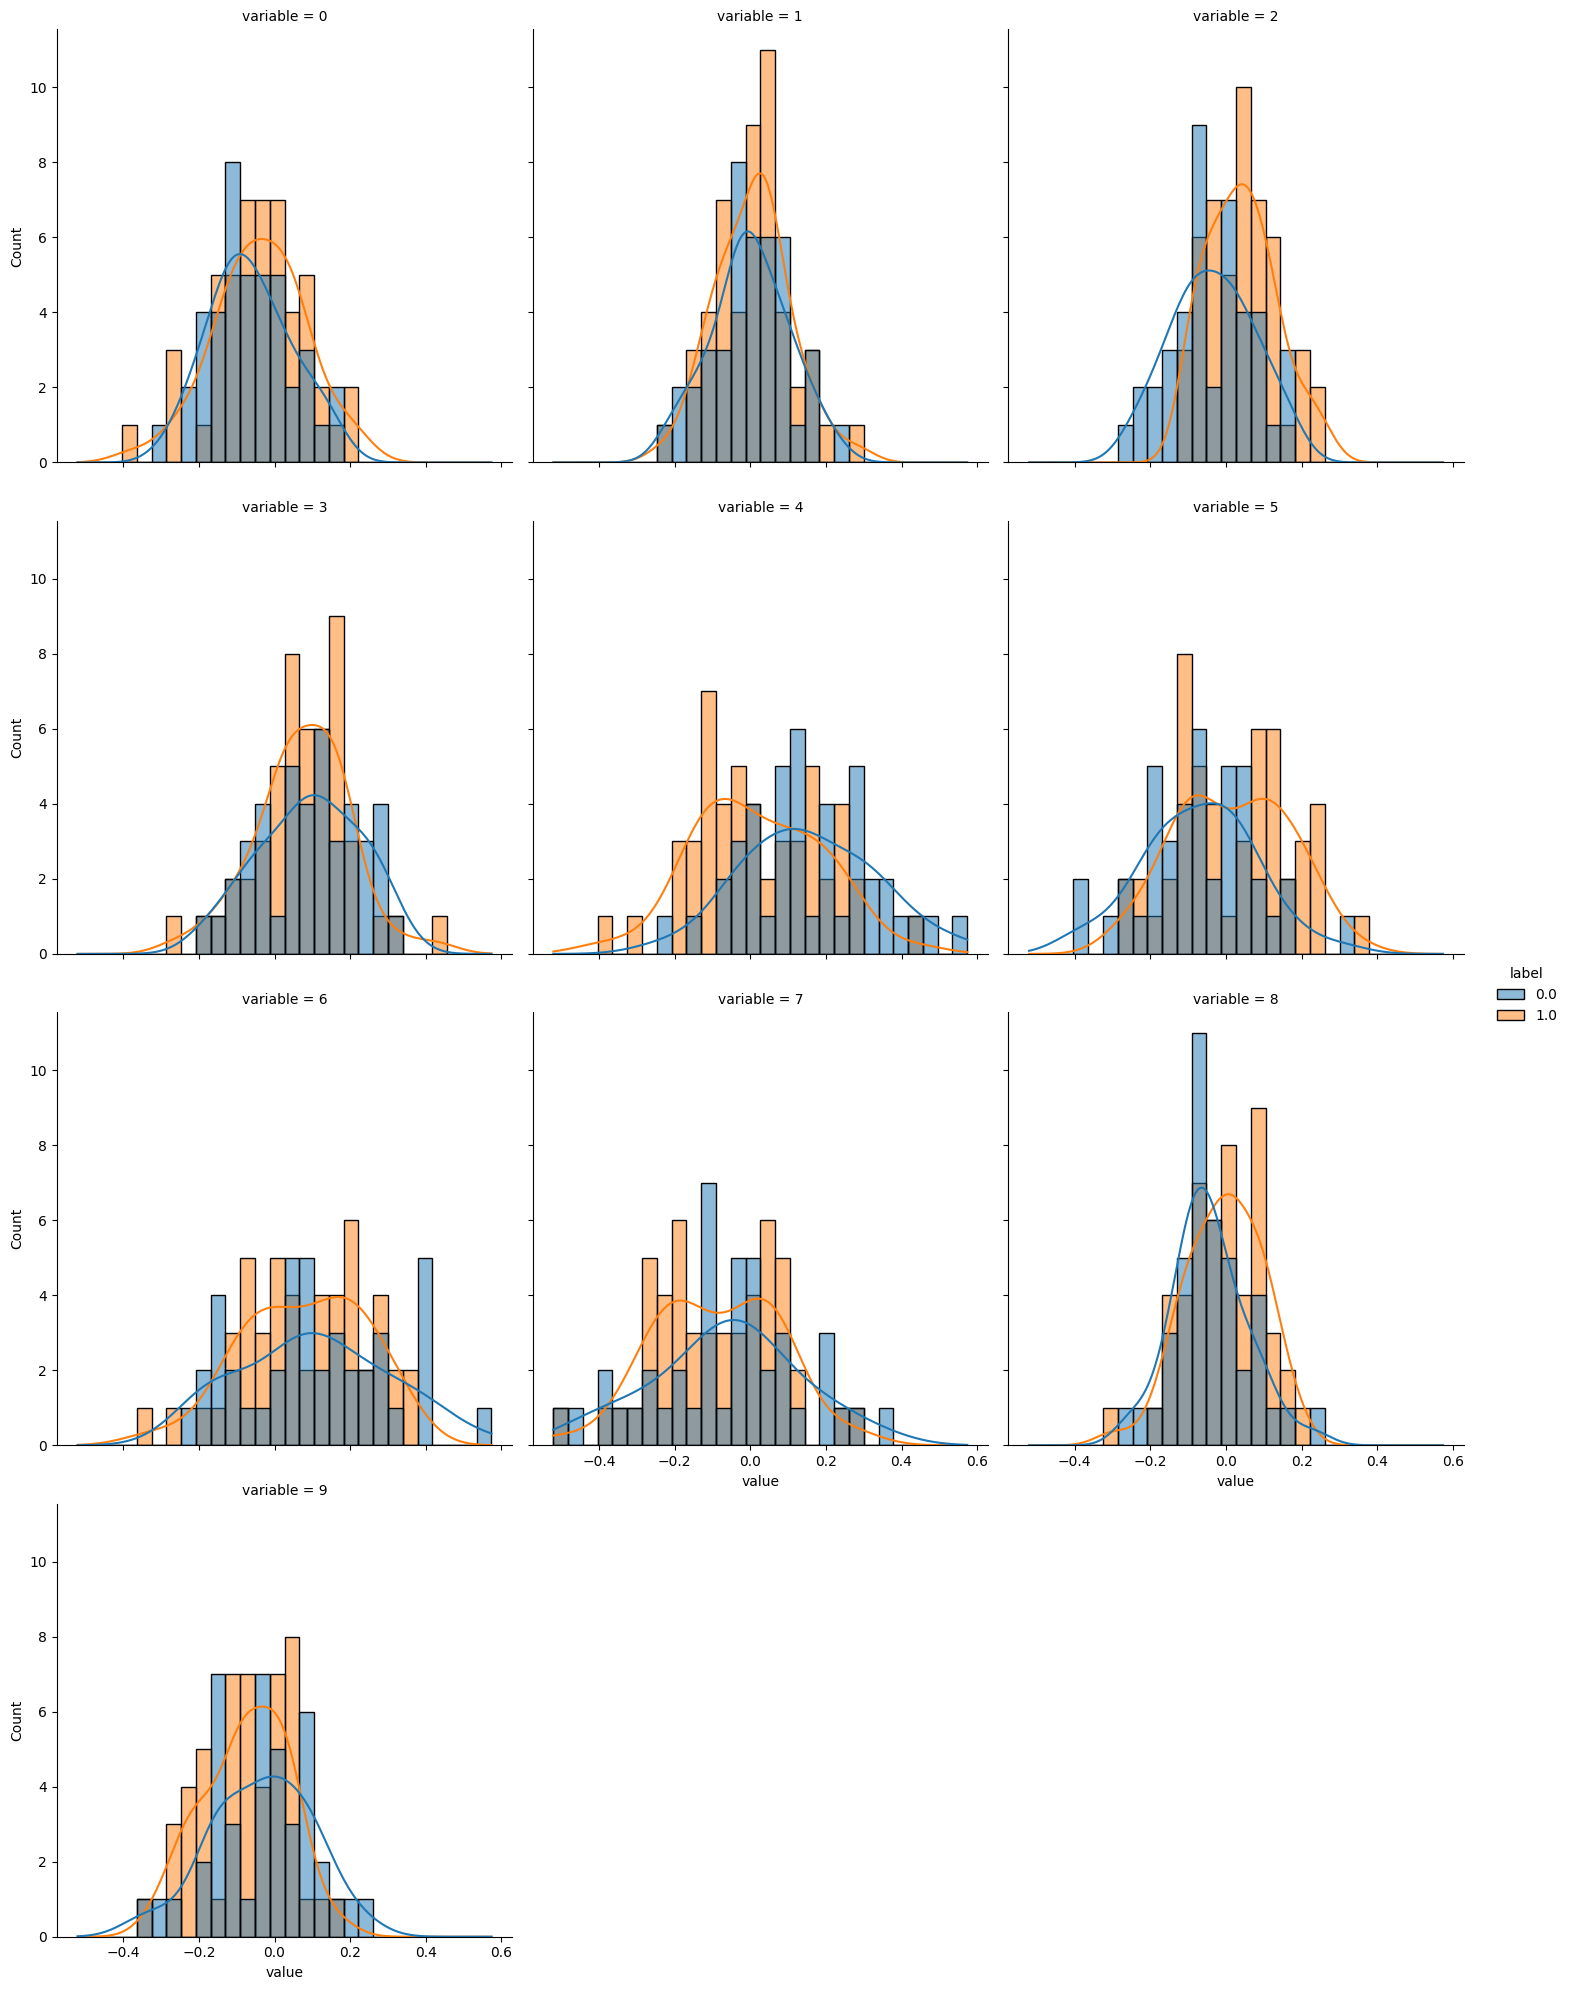

In [16]:
sorted_indices = shapiro_pvalues['linear1'].sort(descending=True)[1][:10]

df_linear_1_normal = pd.DataFrame(data=out_neurons_collector['linear1'][:, sorted_indices])
df_linear_1_normal['label'] = y_test

sns.displot(data=df_linear_1_normal.melt(id_vars=['label']), x='value', hue='label', col='variable', col_wrap=3, alpha=0.5, kde=True);

Admettons que nous avons des neurones que l'on considère comme dissociatifs, pouvons nous aisément repérer les poids ou l'ensemble des poids qui vont maintenir ou créer une dissociation par la suite ? \
Si les poids n'accentuent, ne conservent ou ne créent pas de dissociation alors ça va être difficile de repérer les neurones importants. \
Une de mes hypothèses est que les neurones dont les distributions sont confondues ne sont présents qu'à des fins de régulation et ne peuvent être considérés comme importants car non dissociés.

La question que nous pouvons nous poser maintenant est : quels sont les neurones qui présentent la plus grosse dissociation ? Que ce soit fortement positif ou négatif. Si présence de ReLU alors la négation est considérée comme nul et alors le signal qui est émit ne vient que d'une classe en soi.

Dans la méthode, nous ne pouvons négliger le théorème central limite, bien que nous ayons l'équivalent de 2 variables aléatoires par neurone (l'effet peut être plus remarquable avec plus de classes par exemple). L'union des deux distributions (de la classe 0 et de la classe 1) peut donner une distribution normale. Donc, il serait intéressant de mesurer 2 valeurs :
1. La divergence de *Kullback-Leibler* (sûrement le plus intéressant)
2. La moyenne et l'écart-type.

In [17]:
X1 = np.random.normal(loc=5.0, scale=1.5, size=(10000,))
X2 = np.random.normal(loc=5.0, scale=1.5, size=(1000,))
X3 = np.random.normal(loc=3.0, scale=1.0, size=(50,))
X4 = np.random.normal(loc=5.0, scale=2.0, size=(10000,))

stats.mannwhitneyu(X1, X2), stats.mannwhitneyu(X1, X3), stats.mannwhitneyu(X1, X4)

(MannwhitneyuResult(statistic=5143613.0, pvalue=0.13363630132867785),
 MannwhitneyuResult(statistic=429398.0, pvalue=1.8459917099402294e-18),
 MannwhitneyuResult(statistic=49701588.0, pvalue=0.46481724677383596))

In [18]:
X_positive_1 = df_linear_1_normal[df_linear_1_normal['label'] == 1.][1].to_numpy()
X_negative_1 = df_linear_1_normal[df_linear_1_normal['label'] == 0.][1].to_numpy()

X_positive_9 = df_linear_1_normal[df_linear_1_normal['label'] == 1.][9].to_numpy()
X_negative_9 = df_linear_1_normal[df_linear_1_normal['label'] == 0.][9].to_numpy()

stats.mannwhitneyu(X_positive_1, X_negative_1), stats.mannwhitneyu(X_positive_9, X_negative_9)

(MannwhitneyuResult(statistic=1090.0, pvalue=0.7568458296075415),
 MannwhitneyuResult(statistic=862.0, pvalue=0.1416319469128493))

Utilisons ce test statistique pour déterminer l'importance d'un neurone. Procédons par étapes :
1. Récupérons le dictionnaire des outputs d'une couche
2. Séparons les valeurs par rapport à leur classe
3. Effectuons les tests statistiques suivants :
   1. Si distributions normales ou proches : t-test (ou Student)
   2. Sinon : test de Mann-Whitney U
      1. Si semblables : cherchons voir si la moyenne/variance est similaire

In [19]:
def neuron_is_important(samples: torch.Tensor, positive_indices: torch.Tensor, negative_indices: torch.Tensor) -> bool:
    is_important = False
    X_positive = samples[positive_indices]
    X_negative = samples[negative_indices]

    is_X1_normal = stats.shapiro(X_positive).pvalue > 0.05
    is_X2_normal = stats.shapiro(X_negative).pvalue > 0.05

    if is_X1_normal and is_X2_normal:
        is_important = stats.ttest_ind(X_positive, X_negative, equal_var=False).pvalue < 0.05
    else:
        is_important = stats.mannwhitneyu(X_positive, X_negative).pvalue < 0.05
    
    return is_important

In [20]:
negative_indices = torch.where(y_test == 0)[0]
positive_indices = torch.where(y_test == 1)[0]

layers_important_neurons = {}
layers_non_important_neurons = {}

for layer_name, layer_outputs in out_neurons_collector.items():
    if layer_name == 'fc':
        continue
    linear1 = out_neurons_collector['linear1']

    important_neurons = torch.zeros(size=(layer_outputs.shape[1],), dtype=torch.bool)

    for i in range(layer_outputs.shape[1]):
        samples = layer_outputs[:, i]
        important_neurons[i] = torch.BoolTensor([neuron_is_important(samples, positive_indices, negative_indices)])[0]

    layers_important_neurons[layer_name] = torch.where(important_neurons == True)[0]
    layers_non_important_neurons[layer_name] = torch.where(important_neurons == False)[0]

Pour tester notre méthode, prenons aléatoirement et en répétant 10 fois, des neurones importants, effacons les (à 0) puis évaluons la perte en performance (faire pareil avec les neurones pas importants).

In [21]:
layers_important_neurons

{'linear1': tensor([  1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,  15,
          16,  17,  18,  19,  21,  23,  24,  25,  26,  27,  28,  29,  30,  32,
          34,  37,  38,  43,  44,  47,  49,  50,  51,  52,  55,  57,  58,  61,
          62,  63,  65,  66,  67,  68,  69,  71,  74,  75,  76,  77,  78,  79,
          80,  81,  82,  83,  85,  88,  89,  90,  92,  95,  96,  98,  99, 100,
         101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 115, 118,
         119, 120, 121, 122, 123, 124, 126, 128, 129, 130, 131, 133, 134, 138,
         140, 143, 144, 145, 146, 148, 150, 151, 152, 154, 155, 156, 160, 162,
         163, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178,
         179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
         193, 195, 196, 197, 199, 200, 203, 204, 206, 207, 208, 209, 210, 211,
         212, 213, 216, 217, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231,
         232, 236, 237, 239, 241, 243, 24

In [35]:
def mask_important_neurons(model: nn.Module, important_neurons: Dict[str, torch.Tensor], percentage_masked: float=0.1) -> nn.Module:
    masked_model = deepcopy(model)
    masked_model.eval()
    for layer_name, positive_indices in important_neurons.items():
        mask_size = int(positive_indices.shape[0] * percentage_masked)
        indices = torch.LongTensor(random.sample(positive_indices.tolist(), k=mask_size))

        layer = masked_model.get_submodule(layer_name)
        layer_weights = layer.weight.data
        layer_biases = layer.bias.data
        layer_weights[indices, :] = 0.
        layer_biases[indices] = 0.
        
        layer.weight.data = layer_weights
        layer.bias.data = layer_biases
    
    return masked_model

In [40]:
important_masked_accuracy = []
non_important_masked_accuracy = []
for _ in range(10):
    important_masked_model = mask_important_neurons(submodel, layers_important_neurons, percentage_masked=0.9)
    non_important_masked_model = mask_important_neurons(submodel, layers_non_important_neurons, percentage_masked=0.9)

    important_outputs = important_masked_model(X_test)
    non_important_outputs = non_important_masked_model(X_test)

    important_accuracy = BinaryAccuracy()(important_outputs, y_test.unsqueeze(1))
    non_important_accuracy = BinaryAccuracy()(non_important_outputs, y_test.unsqueeze(1))

    important_masked_accuracy.append(important_accuracy)
    non_important_masked_accuracy.append(non_important_accuracy)

# Pour masquer les neurones il faut masquer tous les poids arrivant à ce neurone.

In [41]:
important_masked_accuracy

[tensor(0.6087),
 tensor(0.6304),
 tensor(0.6196),
 tensor(0.6413),
 tensor(0.6413),
 tensor(0.5652),
 tensor(0.6304),
 tensor(0.6304),
 tensor(0.6413),
 tensor(0.6522)]

In [42]:
non_important_masked_accuracy

[tensor(0.8152),
 tensor(0.8152),
 tensor(0.8043),
 tensor(0.8152),
 tensor(0.8152),
 tensor(0.8152),
 tensor(0.8152),
 tensor(0.8152),
 tensor(0.8152),
 tensor(0.8152)]